In [1]:
import sys
import os
import re
import gc
import itertools
import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse.csr import csr_matrix

from tqdm.auto import trange, tqdm
from collections import Counter, defaultdict
from scipy.sparse import hstack
import pickle
from torch.utils.data import Dataset
from glob import glob
from IPython.display import display as ipython_displpay
from IPython.display import HTML
# from imblearn.over_sampling import RandomOverSampler

In [2]:
import pandas as pd
import numpy as np

In [3]:
import requests

In [4]:
import json

In [18]:
prefix = os.getcwd().split("jdi-qasp-ml")[0]
sys.path.append(os.path.join(prefix, "jdi-qasp-ml"))

dataset_path = os.path.join(prefix, "jdi-qasp-ml", "data/mui_dataset")

In [6]:
# UTILS_LOGGER = 'utils.dataset'
# LOG_FILE_PATH = 'tmp/log.txt'

# os.makedirs(name='tmp', exist_ok=True)

# logger = logging.getLogger(UTILS_LOGGER)
# logger.setLevel(logging.DEBUG)


# formatter = logging.Formatter('%(asctime)s -%(levelname)s - %(module)s:%(filename)s:%(lineno)d - %(message)s')

# console_handler = logging.StreamHandler(sys.stdout)
# console_handler.setFormatter(formatter)

# file_handler = logging.FileHandler(filename=LOG_FILE_PATH, mode='w')
# file_handler.setFormatter(formatter)

# logger.addHandler(console_handler)
# logger.addHandler(file_handler)

# logger.info('Module utils.config was loaded')

In [7]:
# os.listdir()

In [8]:
import seaborn as sns

In [11]:
from utils.dataset_builder import DatasetBuilder
from utils.common import maximize_window

2021-11-09 23:11:22,210 -INFO - config.py:30 - Module utils.config was loaded
2021-11-09 23:11:22,233 -INFO - common.py:120 - Module utils.common is loaded...
2021-11-09 23:11:22,235 -INFO - dataset_builder.py:217 - dataset package is loaded...


In [12]:
from time import sleep

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
WAIT_TIME_SECONDS = 3

In [15]:
os.getcwd()

'/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/notebooks/MUI'

In [16]:
SITE_URLS = [
    "file://" + p.replace("\\", "/") + "/index.html"
    for p in glob(f'{os.path.join(prefix, "jdi-qasp-ml")}/data/mui_dataset/build/*')
]
DATASET_NAMES = [re.search("site-[0-9]+", nm)[0] for nm in SITE_URLS]

In [23]:
DATASET_NAMES[0]

'site-348'

In [17]:
SITE_URLS[0]

'file:///Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/build/site-348/index.html'

2021-11-09 23:13:46,033 -INFO - dataset_builder.py:82 - Dataset name: site-348
2021-11-09 23:13:46,035 -INFO - dataset_builder.py:92 - Create directories to save the dataset
2021-11-09 23:13:46,037 -INFO - dataset_builder.py:130 - Creating driver
2021-11-09 23:13:47,091 -INFO - dataset_builder.py:141 - Chrome web driver is created
2021-11-09 23:13:47,093 -INFO - 3263710195.py:3 - getting page
2021-11-09 23:13:47,890 -INFO - common.py:29 - Window maximized
2021-11-09 23:13:50,892 -INFO - dataset_builder.py:144 - save scrinshot: /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/images/site-348.png
2021-11-09 23:13:52,283 -INFO - dataset_builder.py:188 - Collect features using JS script
2021-11-09 23:13:53,165 -INFO - dataset_builder.py:196 - Save html to /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/html/site-348.html
2021-11-09 23:13:53,189 -INFO - dataset_builder.py:206 - Save parquet to /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/df/site-348.

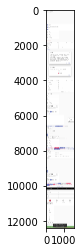

In [19]:
class JDIDatasetBuilder(DatasetBuilder):
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(self.url)
        #driver.set_window_size(width=1500, height=8000)
        maximize_window(driver)
        sleep(WAIT_TIME_SECONDS)
        
with JDIDatasetBuilder(url=SITE_URLS[0], 
                       dataset_name=DATASET_NAMES[0], 
                       headless=True, 
                       dataset_root_path=dataset_path) as builder:
    
    elements_df = builder.dataset
    dataset_json = builder.dataset_json
    plt.imshow(plt.imread(f'{dataset_path}/images/{DATASET_NAMES[0]}.png'))
    
    
# builder = JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True)
# elements_df = builder.dataset
# plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))

In [25]:
from utils.common import maximize_window

def collect_many_ds(dataset_names):
    
    all_dfs = []
    
    with trange(len(dataset_names)) as bar:

        for ds_name in dataset_names:
            elements_df = pd.read_pickle(f"{dataset_path}/df/{ds_name}.pkl")
            elements_df['idx'] = elements_df.index
            elements_df['ds_name'] = ds_name
            all_dfs.append(elements_df)
                
            bar.update(1)
            
    df_sites = pd.concat(all_dfs, axis=0)      
    return df_sites

### \# make this cell a CODE cell to collect the dataset

````python
elements_df = collect_many_ds(SITE_URLS, DATASET_NAMES)
elements_df.to_pickle('MUI_model/dataset/elements_df.pkl') # CAUTION: Do not use .parquet, it breaks ["attributes"] column
````

In [26]:
elements_df = collect_many_ds(DATASET_NAMES)
elements_df.to_pickle(f'{dataset_path}/elements_df.pkl') # CAUTION: Do not use .parquet, it breaks ["attributes"] column

100%|██████████| 500/500 [00:47<00:00, 10.64it/s]


In [30]:
# reload dataset

elements_df = pd.read_pickle(f'{dataset_path}/elements_df.pkl')
display(elements_df.shape)


(455792, 15)

In [27]:
elements_df['idx'] = elements_df.index

In [28]:
print(len(elements_df.ds_name.unique()))
elements_df.head()

500


,attributes,displayed,element_id,height,onmouseenter,onmouseover,parent_id,style,tag_name,text,width,x,y,idx,ds_name
0,{'lang': 'en'},True,7992856186888322909593257640,6203.4375,None,None,None,"[accent-color, align-content, align-items, ali...",HTML,incididunt velit\naliquip enim sunt nulla labo...,785.0,0.0,0.0,0,site-348
1,None,False,5868675332888322901021013825,0.0000,None,None,7992856186888322909593257640,"[accent-color, align-content, align-items, ali...",HEAD,React App\n.MuiSvgIcon-root {\n fill: current...,0.0,0.0,0.0,1,site-348
2,{'charset': 'utf-8'},False,6889591497888322903601531937,0.0000,None,None,5868675332888322901021013825,"[accent-color, align-content, align-items, ali...",META,,0.0,0.0,0.0,2,site-348
3,"{'href': './favicon.ico', 'rel': 'icon'}",False,6720431150888322907795030138,0.0000,None,None,5868675332888322901021013825,"[accent-color, align-content, align-items, ali...",LINK,,0.0,0.0,0.0,3,site-348
4,"{'content': 'width=device-width,initial-scale=...",False,3786683135888322902287231227,0.0000,None,None,5868675332888322901021013825,"[accent-color, align-content, align-items, ali...",META,,0.0,0.0,0.0,4,site-348


In [29]:
# dataset_json

In [33]:
from utils.common import load_gray_image
from matplotlib.patches import Rectangle

## Assign Labels

In [34]:
elements_df['label'] = elements_df.attributes.apply(lambda x: x.get('data-label') if x is not None else None).fillna('n/a')
elements_df['bin_label'] = elements_df.label != 'n/a'


In [35]:
elements_df[elements_df['label'] != 'n/a'].head().T

,121,124,131,148,159
attributes,"{'aria-label': 'maximum height', 'data-label':...",{'class': 'MuiSlider-root MuiSlider-colorPrima...,{'class': 'MuiPaper-root MuiStepper-root MuiSt...,{'class': 'MuiTypography-root MuiTypography-ca...,{'class': 'MuiList-root jss10 MuiList-padding'...
displayed,True,True,True,True,True
element_id,8198732366888322901030261108,5348282396888322902106031983,4284915480888322901328248108,2388881624888322900714028840,5015591825888322909921944116
height,66.0,300.0,201.0,14.0,234.0
onmouseenter,None,None,None,None,None
onmouseover,None,None,None,None,None
parent_id,5123143663888322903905336077,9151352428888322900687267668,5123143663888322903905336077,7322769995888322902592930815,5123143663888322903905336077
style,"[accent-color, align-content, align-items, ali...","[accent-color, align-content, align-items, ali...","[accent-color, align-content, align-items, ali...","[accent-color, align-content, align-items, ali...","[accent-color, align-content, align-items, ali..."
tag_name,TEXTAREA,SPAN,DIV,SPAN,UL
text,,,incididunt velit\naliquip enim sunt nulla labo...,Optional,"Photos\n\nJan 9, 2014\n\nWork\n\nJan 7, 2014\n..."


## EDA

#### Tag_name

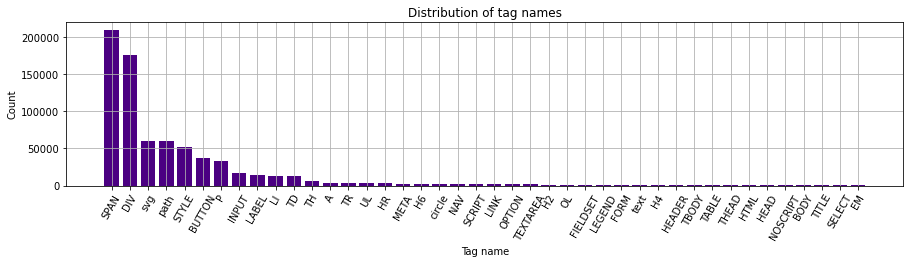

In [36]:
def plot_tag_names(df, col):
    plt.figure(figsize=(15,3))
    plt.grid(True)
    plt.bar(df[col].value_counts().index, height=df[col].value_counts().values, color='indigo')
    plt.title('Distribution of tag names')
    plt.xlabel('Tag name')
    plt.ylabel('Count')
    plt.xticks(rotation=60);

plot_tag_names(elements_df, 'tag_name')

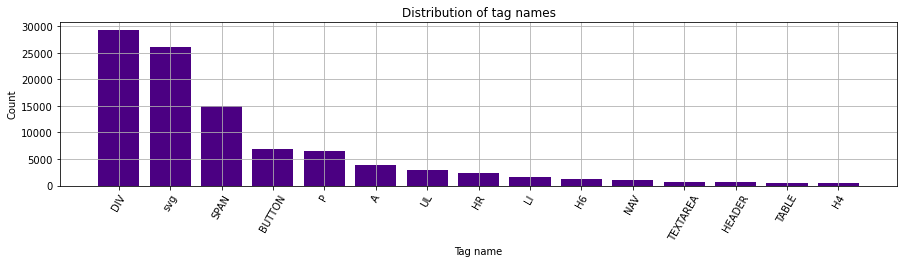

In [37]:
plot_tag_names(elements_df[elements_df.bin_label], 'tag_name')

**CAUTION: We have to pay attention to these tags: SELECT, TABLE, FORM, LINK , UL, LI**

#### Label

In [38]:
elements_df.bin_label.value_counts()

False    630820
True      99296
Name: bin_label, dtype: int64

In [39]:
elements_df.bin_label.value_counts().values / elements_df.shape[0]

array([0.86399969, 0.13600031])

icon                 26068
typography            9377
chip                  9363
radio                 7314
button                7163
checkbox              4100
divider               3963
link                  3171
list                  2695
grid                  2562
accordion             2338
avatar                1556
progress              1416
paper                 1142
badge                 1079
switch                 950
text-field             824
card                   728
menu                   727
tabs                   718
alert                  712
backdrop               705
container              703
drawer                 701
textarea-autosize      701
box                    691
select                 690
app-bar                682
slider                 678
stepper                676
snackbar               666
bottom-navigation      664
popper                 662
radiogroup             662
popover                644
breadcrumbs            639
table                  528
b

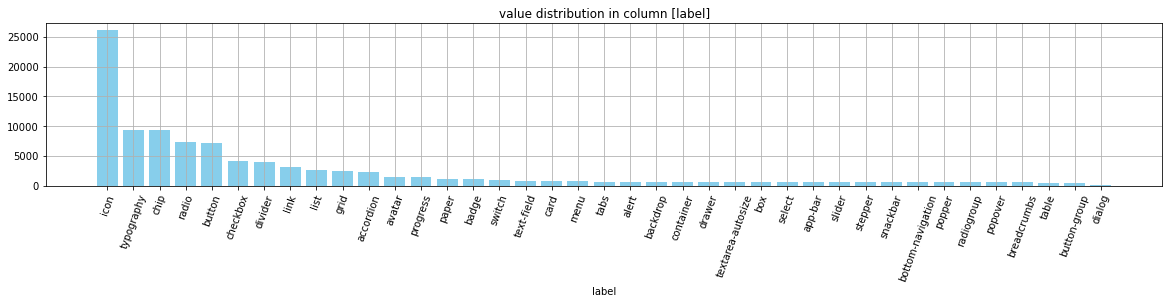

In [40]:
def plot_columns(df, col):
    s = df[df['label'] != 'n/a'].label.value_counts()
    plt.figure(figsize=(20, 3))
    plt.grid(True)
    plt.bar(x=s.index, height = s.values, color='skyblue')
    plt.xticks(rotation=70); 
    plt.xlabel(col)
    plt.title(f"value distribution in column [{col}]")
    display(s)
    
plot_columns(elements_df, 'label')

#### Explore other attributes

In [41]:
elements_df.attributes[:30]

0                                        {'lang': 'en'}
1                                                  None
2                                  {'charset': 'utf-8'}
3              {'href': './favicon.ico', 'rel': 'icon'}
4     {'content': 'width=device-width,initial-scale=...
5         {'content': '#000000', 'name': 'theme-color'}
6     {'content': 'Web site created using create-rea...
7     {'href': './logo192.png', 'rel': 'apple-touch-...
8        {'href': './manifest.json', 'rel': 'manifest'}
9                                                  None
10          {'data-jss': '', 'data-meta': 'MuiSvgIcon'}
11           {'data-jss': '', 'data-meta': 'MuiAvatar'}
12      {'data-jss': '', 'data-meta': 'MuiTouchRipple'}
13       {'data-jss': '', 'data-meta': 'MuiButtonBase'}
14             {'data-jss': '', 'data-meta': 'MuiChip'}
15       {'data-jss': '', 'data-meta': 'MuiIconButton'}
16    {'data-jss': '', 'data-meta': 'PrivateSwitchBa...
17         {'data-jss': '', 'data-meta': 'MuiChe

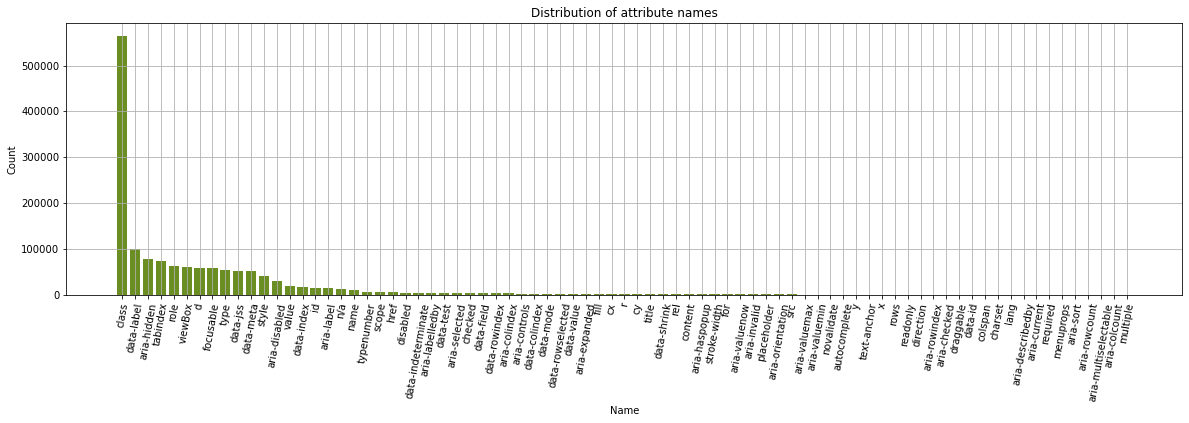

In [42]:
def plot_attr_names(df, col):
    attr_names = df[col].apply(lambda x: list(x.keys()) if x is not None else ['n/a'])
    attr_names = list(itertools.chain.from_iterable(attr_names.to_list()))
    plt.figure(figsize=(20,5))
    plt.grid(True)
    
    plt.bar(pd.Series(attr_names).value_counts().index, 
            height=pd.Series(attr_names).value_counts().values, 
            color='olivedrab')
    
    plt.title('Distribution of attribute names')
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.xticks(rotation=80);

plot_attr_names(elements_df, 'attributes')

In [43]:
attr_names = elements_df['attributes'].apply(lambda x: list(x.keys()) if x is not None else ['n/a'])
attr_names = list(itertools.chain.from_iterable(attr_names.to_list()))
attr_names

['lang',
 'n/a',
 'charset',
 'href',
 'rel',
 'content',
 'name',
 'content',
 'name',
 'content',
 'name',
 'href',
 'rel',
 'href',
 'rel',
 'n/a',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',
 'data-meta',
 'data-jss',

In [44]:
pd.Series(attr_names).value_counts()['class']/len(elements_df) #77% of elements have a class attribute

0.7726744791238652

- ## [class] attribute content, and filter out [n/a] elemets:

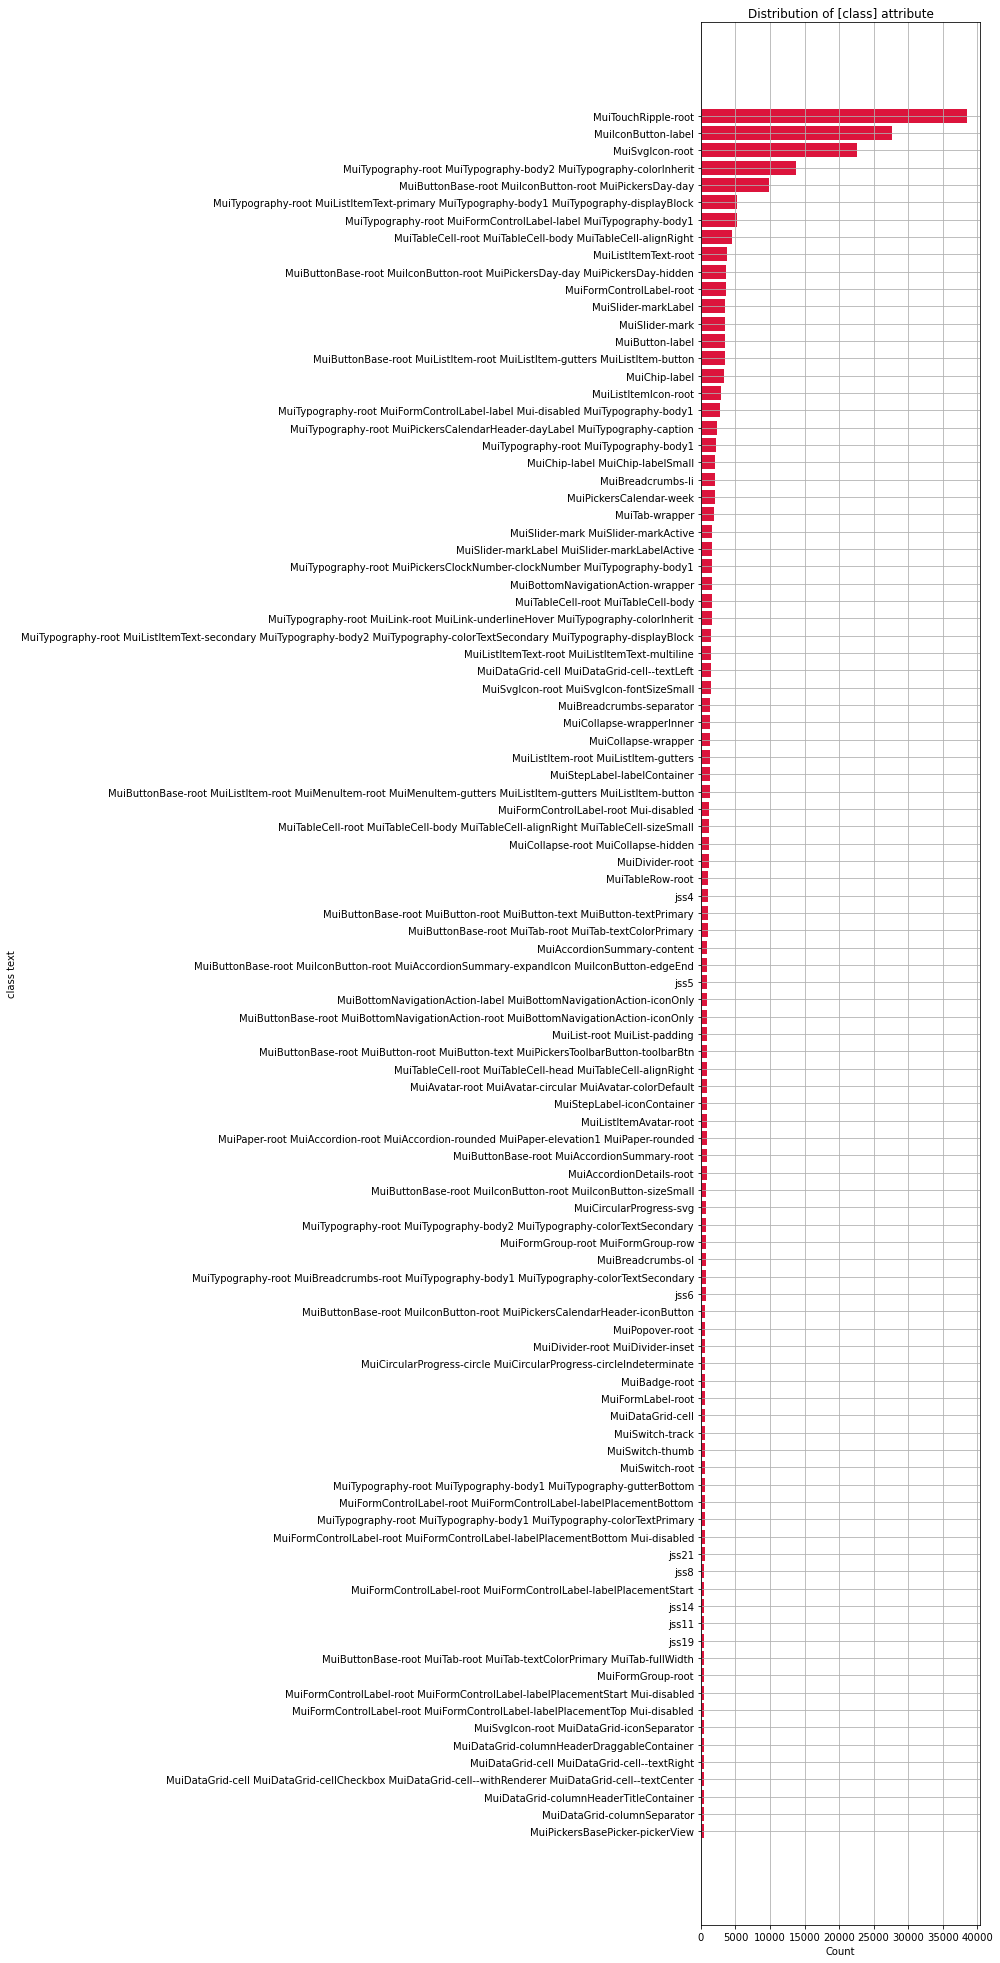

In [50]:
def plot_class_names(df, col, attribute, thresh = 50, color = 'crimson', height = 35):
    
    class_values = df[col].apply(lambda x: x.get(attribute) if x is not None else 'n/a').fillna('n/a')
    
    classes = pd.DataFrame({'name':class_values.value_counts().index, 'value':class_values.value_counts().values})
    classes = classes[classes['name'] != 'n/a']
    
    plt.figure(figsize=(5, height)),
    plt.grid(True)
    plt.barh(classes['name'][classes['value'] > thresh][:100], classes['value'][classes['value']>thresh][:100].astype('int'), color=color)
    plt.title(f'Distribution of [{attribute}] attribute')
    axes = plt.gca()
    axes.invert_yaxis() 
    plt.ylabel(f'{attribute} text')
    plt.xlabel('Count')
    # plt.ticks(rotation='vertical');
    
plot_class_names(elements_df, 'attributes', 'class')

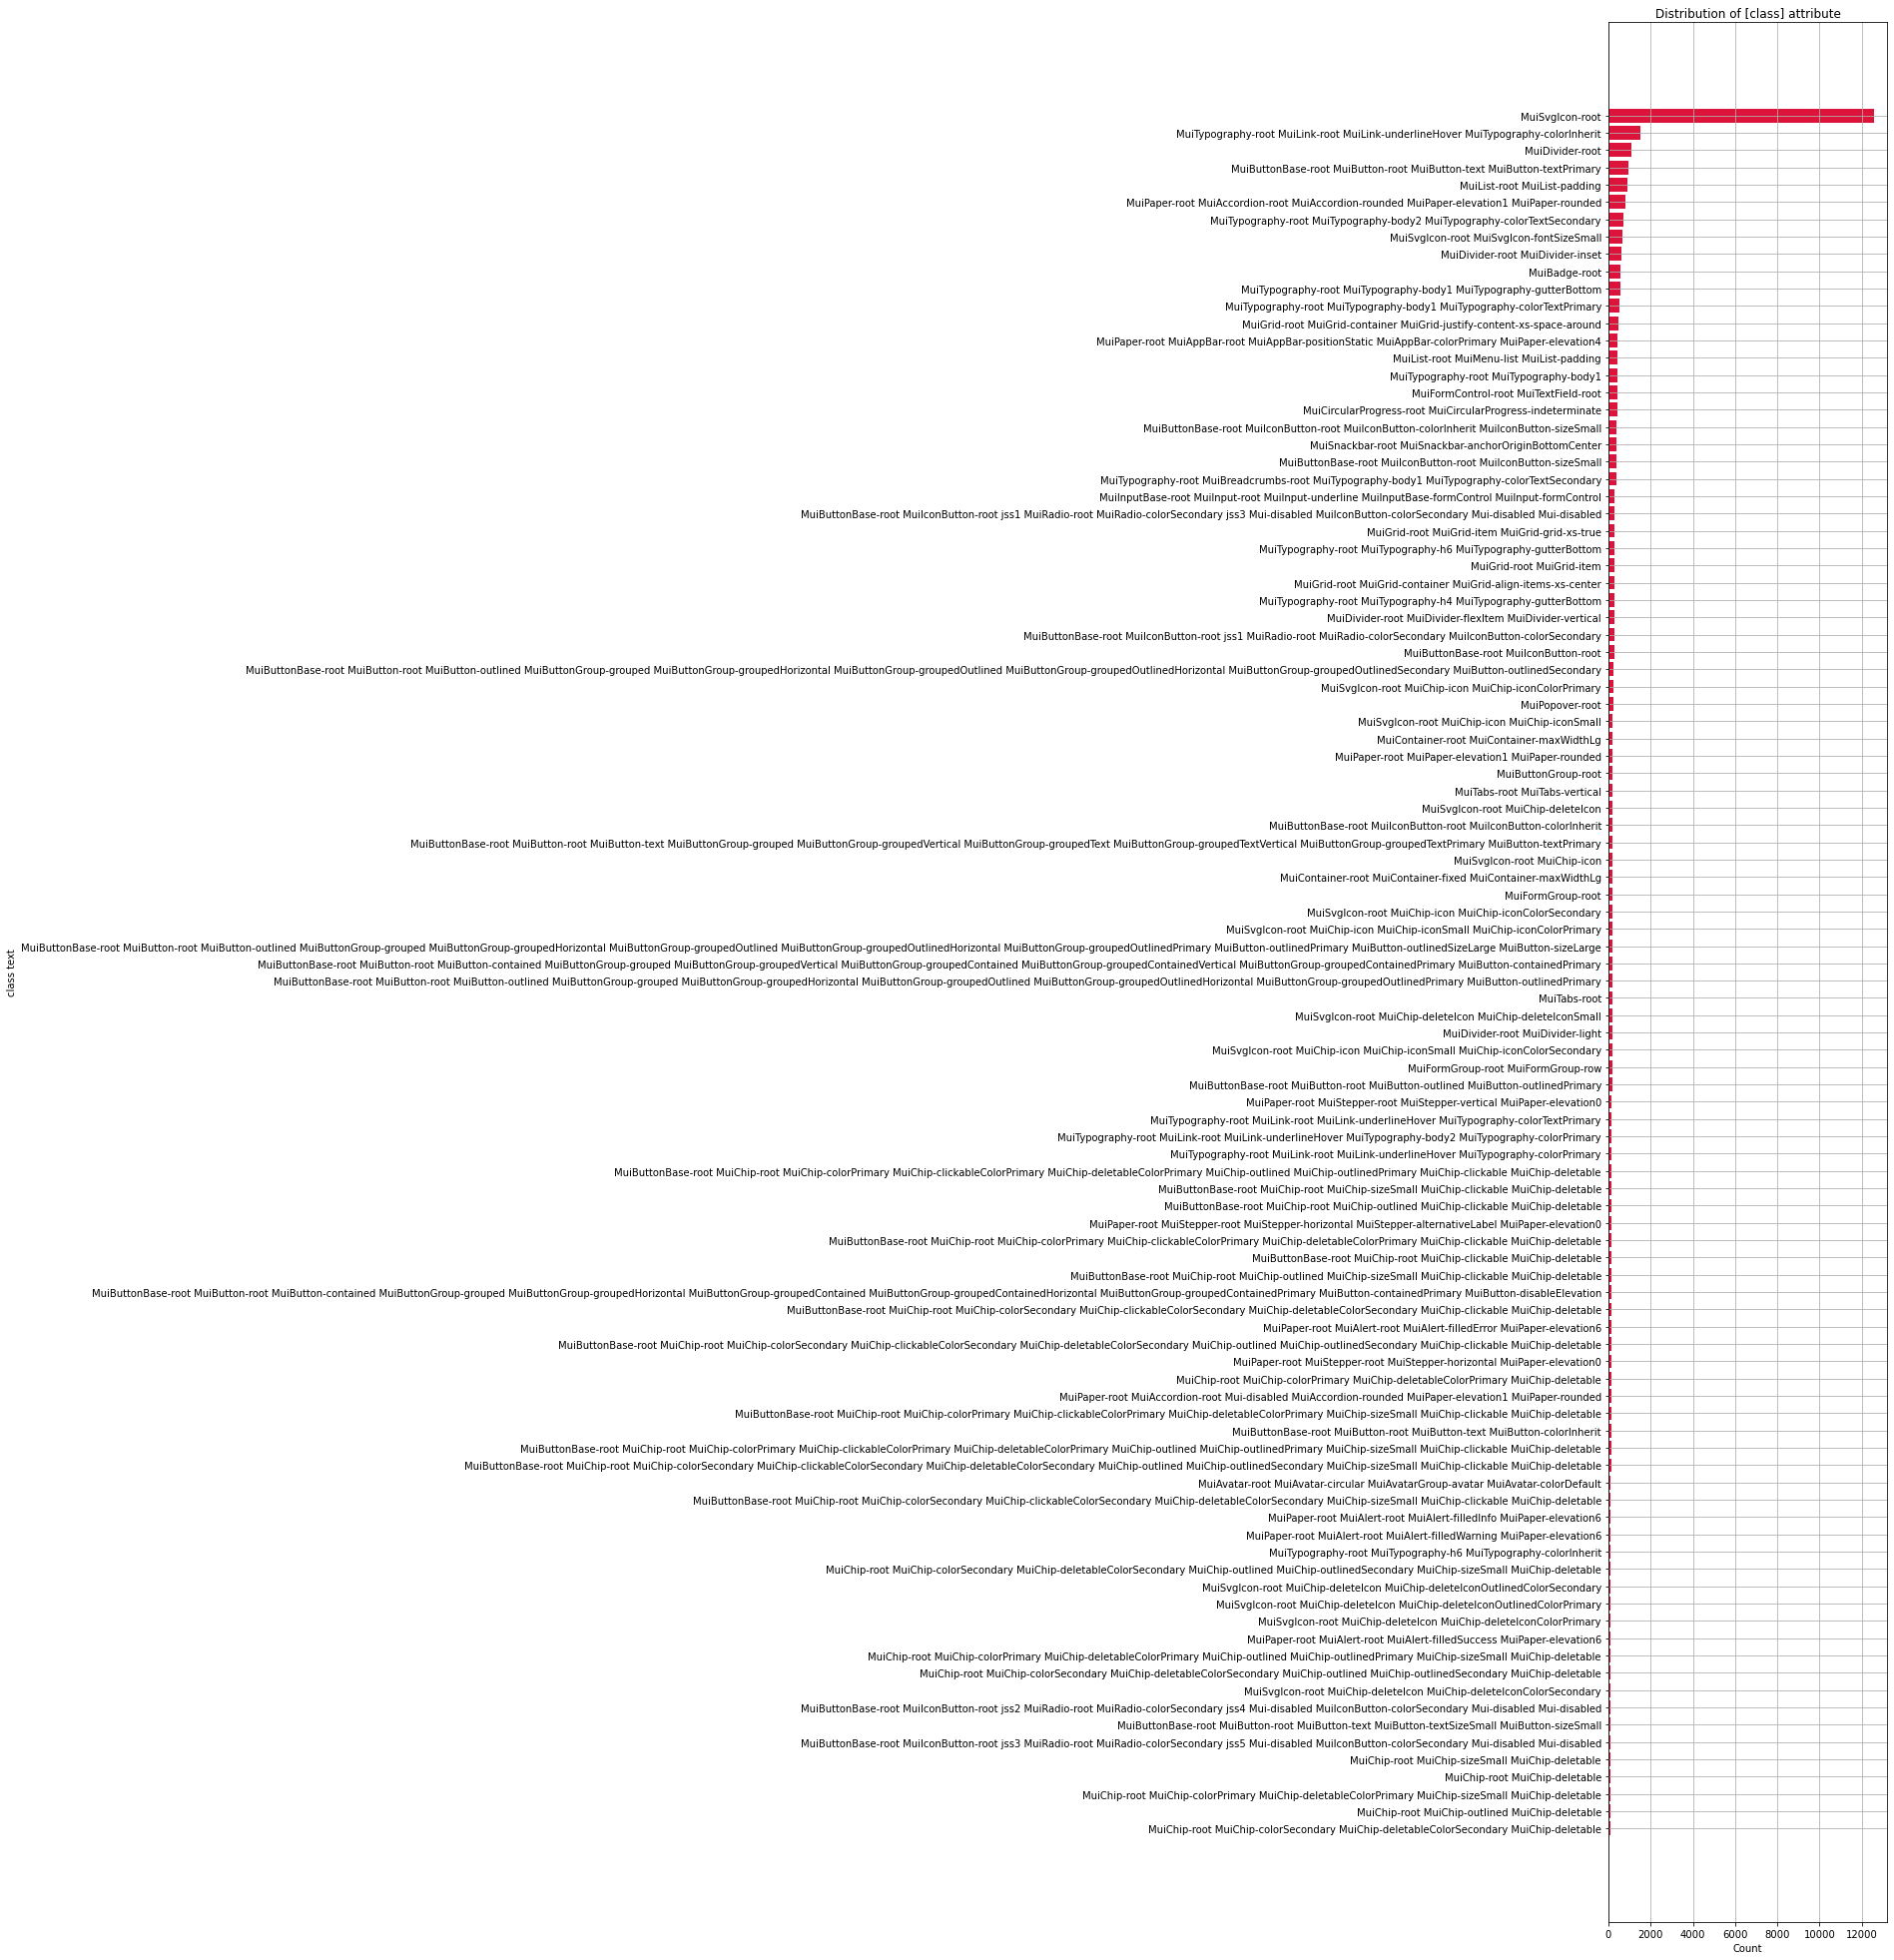

In [51]:
plot_class_names(elements_df[elements_df.bin_label], 'attributes', 'class')

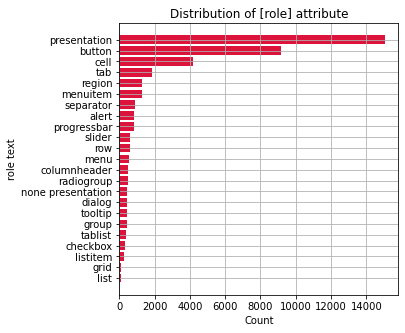

In [52]:
plot_class_names(elements_df, 'attributes', 'role', thresh = 0, height=5)

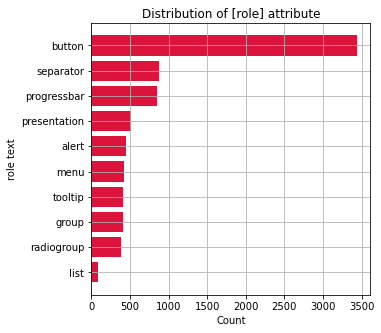

In [53]:
plot_class_names(elements_df[elements_df.bin_label], 'attributes', 'role', thresh = 0, height=5)

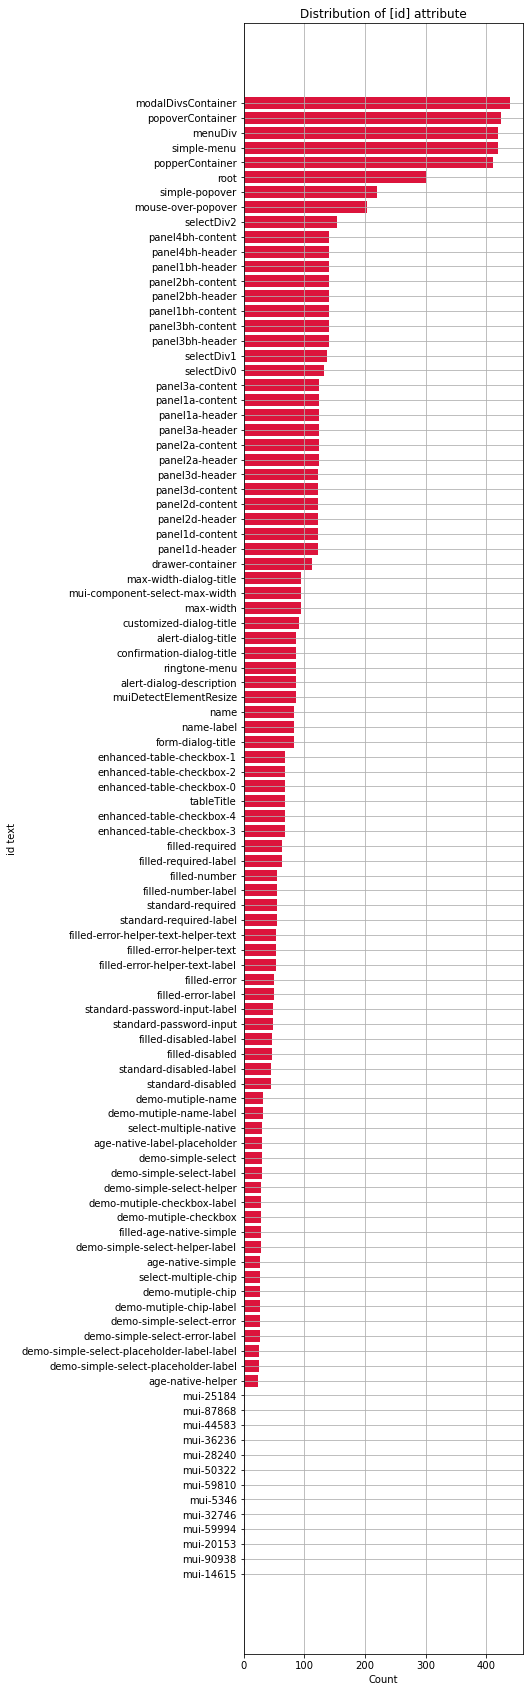

In [54]:
plot_class_names(elements_df, 'attributes', 'id', thresh = 0, height=30)

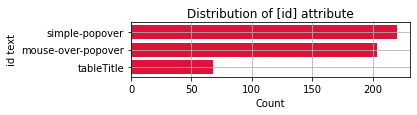

In [55]:
plot_class_names(elements_df[elements_df.bin_label], 'attributes', 'id', thresh = 0, height=1)

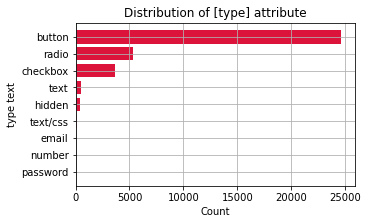

In [56]:
plot_class_names(elements_df, 'attributes', 'type', thresh = 0, height=3)

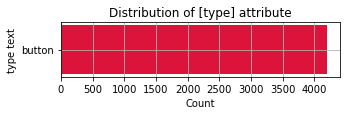

In [57]:
plot_class_names(elements_df[elements_df.bin_label], 'attributes', 'type', thresh = 0, height=1)

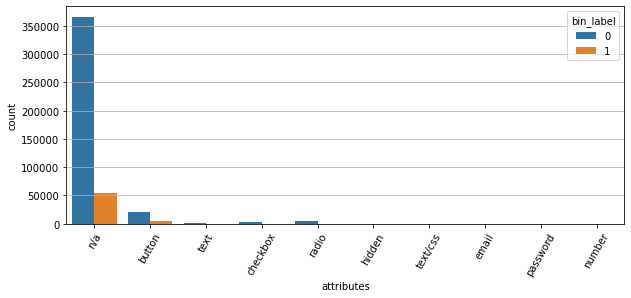

In [58]:
type_values = elements_df['attributes'].apply(lambda x: x.get('type') if x is not None else 'n/a').fillna('n/a')
plt.figure(figsize=(10,4))
plt.grid(True)
sns.countplot(x=type_values, hue = elements_df['bin_label'].astype(int), data=elements_df)
plt.xticks(rotation=60);


In [59]:
aria_hid_values = elements_df['attributes'].apply(lambda x: x.get('aria-hidden') if x is not None else 'n/a').fillna('n/a')
aria_hid_values.value_counts()/elements_df.shape[0]

n/a     0.895393
true    0.104607
Name: attributes, dtype: float64

In [60]:
aria_hid_values = elements_df[elements_df.bin_label]['attributes'].apply(lambda x: x.get('aria-hidden') if x is not None else 'n/a').fillna('n/a')
aria_hid_values.value_counts()/elements_df[elements_df.bin_label].shape[0]

n/a     0.72144
true    0.27856
Name: attributes, dtype: float64

In [61]:
viewBox_values = elements_df[elements_df.label != 'n/a']['attributes'].apply(lambda x: x.get('viewBox') if x is not None else 'n/a').fillna('n/a')

In [62]:
viewBox_values.value_counts()

n/a          43294
0 0 24 24    15609
Name: attributes, dtype: int64

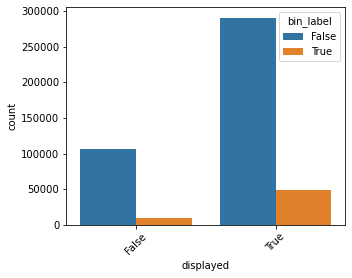

In [63]:
plt.figure(figsize=(5,4))
sns.countplot(x=elements_df['displayed'], hue = elements_df.bin_label)
plt.xticks(rotation=45);

In [64]:
from scipy.stats import chi2_contingency
chi2_contingency(pd.crosstab(elements_df['displayed'],elements_df.bin_label))


(2284.7254229204555,
 0.0,
 1,
 array([[101443.57867404,  15055.42132596],
        [295445.42132596,  43847.57867404]]))

- ## data-metadata

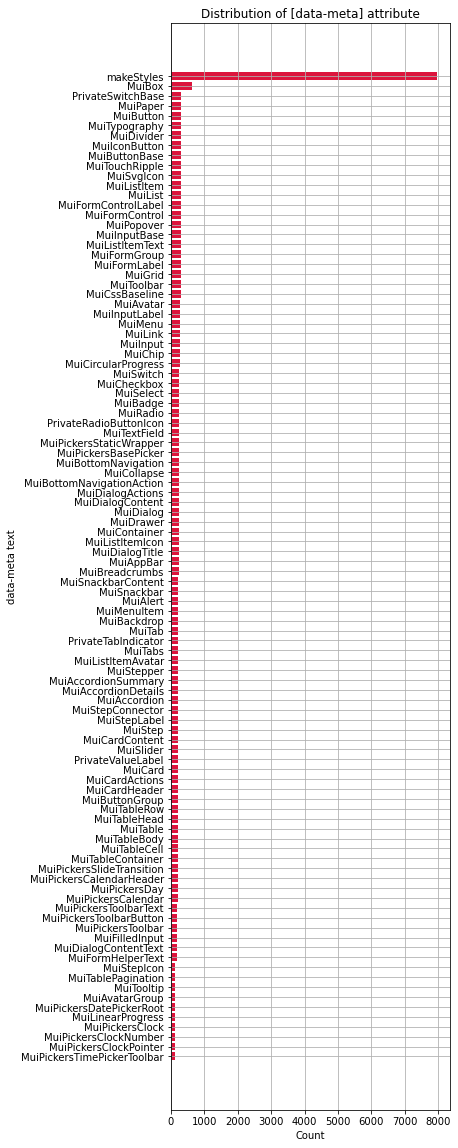

In [65]:
plot_class_names(elements_df, 'attributes', 'data-meta', thresh = 0, height=20)

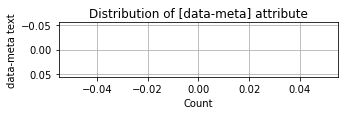

In [66]:
plot_class_names(elements_df[elements_df.bin_label], 'attributes', 'data-meta', thresh = 0, height=1)

- ## tag D is useless

In [67]:
# plot_class_names(elements_df, 'attributes', 'd', thresh = 0, height=35)

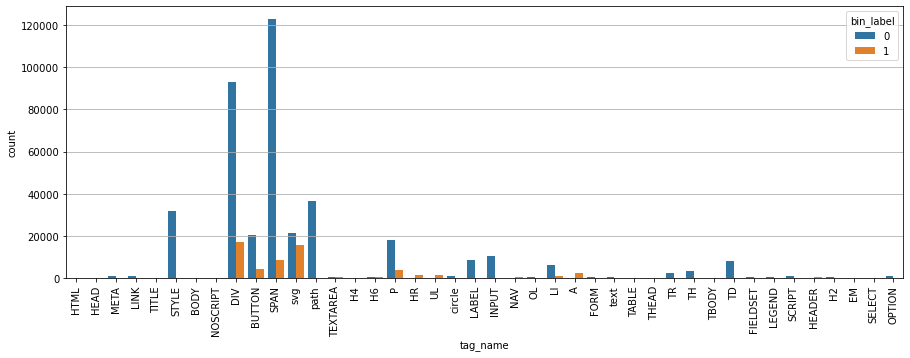

In [68]:
plt.figure(figsize=(15,5))
plt.grid(True)
sns.countplot(x=elements_df['tag_name'], hue = elements_df.bin_label.astype(int), data=elements_df)
plt.xticks(rotation=90);

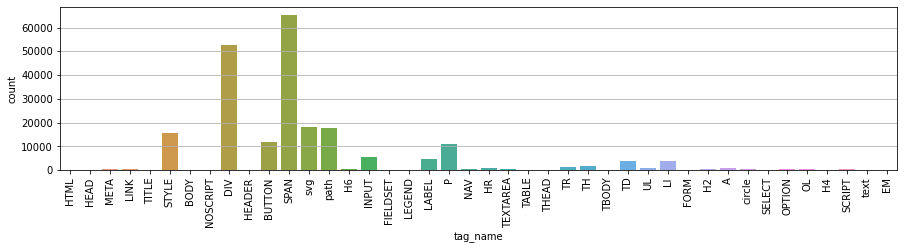

In [53]:
plt.figure(figsize=(15,3))
plt.grid(True)
sns.countplot(x=elements_df.tag_name) #, data=elements_df)
plt.xticks(rotation=90);

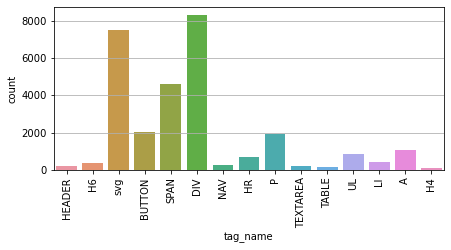

In [54]:
plt.figure(figsize=(7,3))
plt.grid(True)
sns.countplot(x=elements_df[elements_df.bin_label].tag_name) #, data=elements_df)
plt.xticks(rotation=90);

- ## attribute ["class"]

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

In [56]:
attr_class_series = elements_df.attributes.apply(lambda x: None if x is None else x.get('class')).fillna('')
attr_class_series.value_counts()

                                                                                                               50623
MuiTouchRipple-root                                                                                            18789
MuiIconButton-label                                                                                            13442
MuiSvgIcon-root                                                                                                11244
MuiTypography-root MuiTypography-body2 MuiTypography-colorInherit                                               6678
                                                                                                               ...  
MuiSlider-thumb MuiSlider-thumbColorPrimary jss12 jss11                                                            1
MuiTypography-root jss41 MuiTypography-caption MuiTypography-colorTextSecondary MuiTypography-displayBlock         1
MuiAvatar-root MuiAvatar-circular jss73 MuiAvatarGroup-avatar Mu

In [57]:
cv = CountVectorizer()

In [58]:
attr_class_series.values

array(['', '', '', ..., '', '', ''], dtype=object)

In [59]:
cv.fit(attr_class_series.values)

CountVectorizer()

In [60]:
len(cv.vocabulary_.keys())

489

In [61]:
vocabulary = sorted([v for v in cv.vocabulary_.keys() if re.match(r'^[a-z]+$',v ) and len(v) > 2])

In [62]:
len(vocabulary)

370

In [63]:
from scipy.stats import chi2_contingency

In [64]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(elements_df['label'], elements_df['tag_name'].fillna('n/a')))

In [65]:
len(expected[expected < 5])/len(expected)

30.4

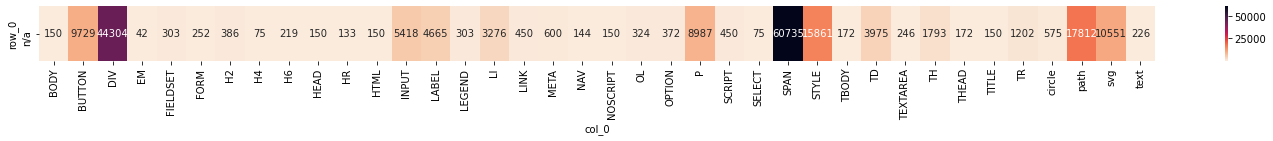

In [66]:
plt.figure(figsize=(25, 1))

sns.heatmap(
    pd.crosstab(
        np.array(elements_df['label'][elements_df['label'] == 'n/a']),
        np.array(elements_df['tag_name'][elements_df['label'] == 'n/a'])
    ), 
    cmap='rocket_r', annot=True, fmt='g'
);

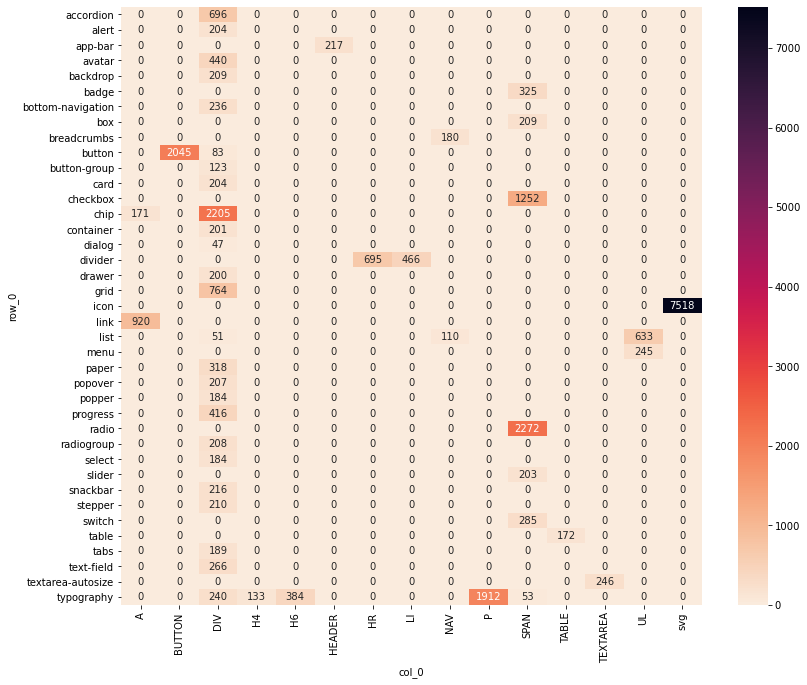

In [67]:
plt.figure(figsize=(13,11))
sns.heatmap(
    pd.crosstab(np.array(elements_df['label'][elements_df['label'] != 'n/a']),
                np.array(elements_df['tag_name'][elements_df['label'] != 'n/a'])), 
    cmap='rocket_r', 
    annot=True, 
    fmt='g'
);

In [68]:
elements_df['class'] = elements_df.attributes.apply(lambda x: None if x is None else x.get('class')).fillna('')

In [69]:
elements_df['class']

0                          
1                          
2                          
3                          
4                          
               ...         
1382                       
1383    MuiTouchRipple-root
1384                       
1385                       
1386                       
Name: class, Length: 223524, dtype: object

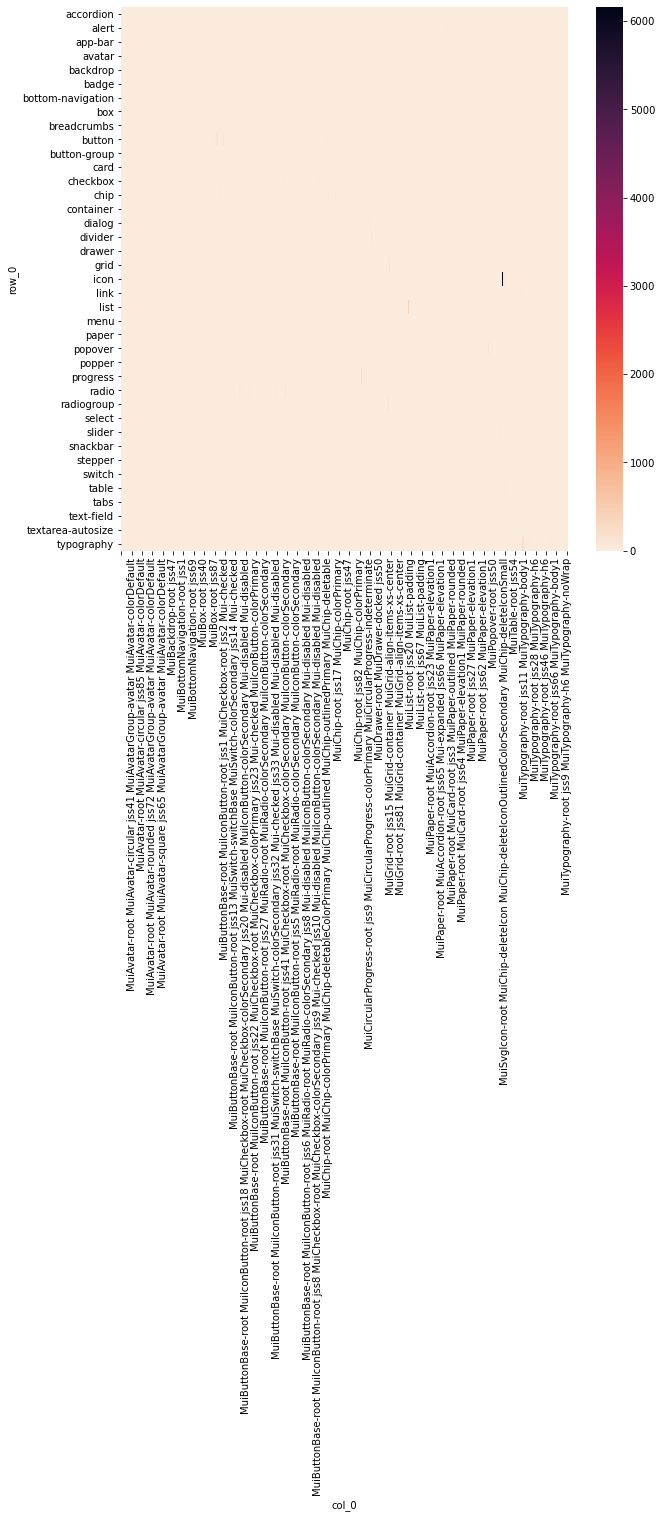

In [70]:
plt.figure(figsize=(10,10))

sns.heatmap(
    pd.crosstab(np.array(elements_df['label'][elements_df['label'] != 'n/a']),
                np.array(elements_df['class'][elements_df['label'] != 'n/a'])), 
    cmap='rocket_r',
    fmt='g'
);

In [71]:
from collections import defaultdict

In [72]:
siblings_dict = defaultdict(dict)
with trange(elements_df.shape[0]) as bar:
    
    for idx, r in elements_df.iterrows():
        if (r.parent_id == r.element_id) or (r.parent_id is None):
            bar.update(1)
            continue

        p = siblings_dict[r.parent_id]
        #print(p)
        #print(siblings_dict)
        p[r.element_id] = idx
        #print(p)
        #print(siblings_dict)
        bar.update(1)

  0%|          | 0/223524 [00:00<?, ?it/s]

#   Collecting 120 datasets (train_dataset)

````python
%%time
n_datasets = 120
df120 = collect_many_ds(SITE_URLS[:n_datasets], DATASET_NAMES[:n_datasets])
df120.to_pickle('MUI_model/dataset/df120sites.pkl')

# ~ 15 min
````

In [45]:
# %%time
# n_datasets = 250
# df250 = collect_many_ds(SITE_URLS[:n_datasets], DATASET_NAMES[:n_datasets])
# df250.to_pickle('data/mui_dataset/df250sites.pkl')

In [46]:
# df250 = pd.read_pickle('data/mui_dataset/df250sites.pkl')

In [47]:
# df250.head()